**CSE 464 - Case Study 2**


---

Mahny Barazandehtar - 20210702004

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.feature_selection import RFE

In [ ]:
# Load the dataset
file_path = "Tetuan-City-power-consumption.csv"
data = pd.read_csv(file_path)

# Preprocess the timestamp
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month
data['Weekday'] = data['DateTime'].dt.weekday

# Normalize numerical columns
numerical_cols = ['Temperature', 'Humidity', 'Wind Speed', 'Zone 1 Power Consumption',
                  'Zone 2  Power Consumption', 'Zone 3  Power Consumption']
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

print("\nPreprocessed Data:")
print(data.head())


Preprocessed Data:
             DateTime  Temperature  Humidity  Wind Speed  \
0 2017-01-01 00:00:00     0.090091  0.748382    0.005130   
1 2017-01-01 00:10:00     0.086146  0.756770    0.005130   
2 2017-01-01 00:20:00     0.083399  0.756770    0.004663   
3 2017-01-01 00:30:00     0.078176  0.762761    0.005130   
4 2017-01-01 00:40:00     0.072736  0.771148    0.004819   

   general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                  0.051          0.119                  0.526251   
1                  0.070          0.085                  0.415545   
2                  0.062          0.100                  0.397623   
3                  0.091          0.096                  0.374149   
4                  0.048          0.085                  0.350834   

   Zone 2  Power Consumption  Zone 3  Power Consumption  Hour  Day  Month  \
0                   0.262361                   0.343368     0    1      1   
1                   0.374886                   0.3

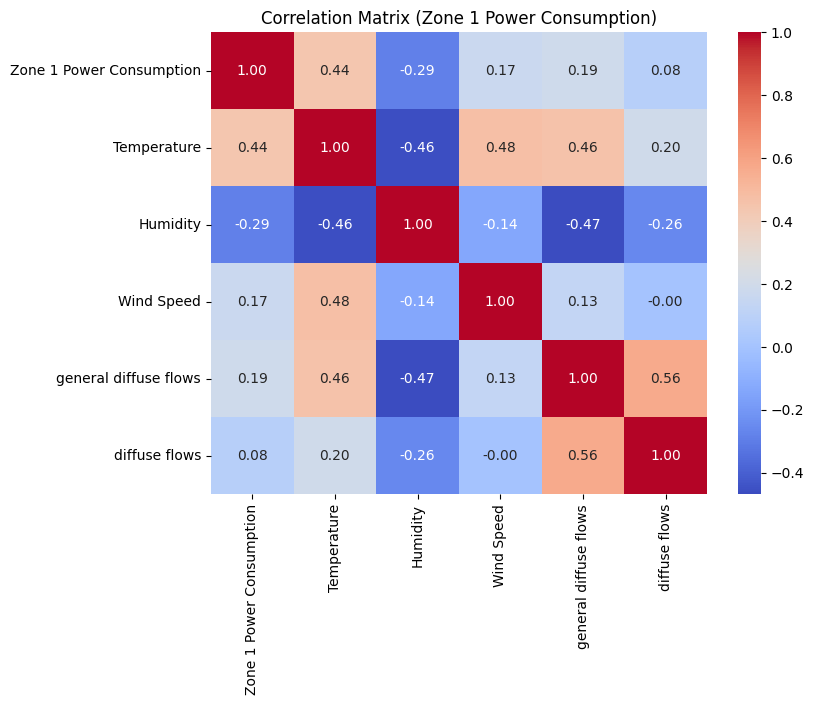

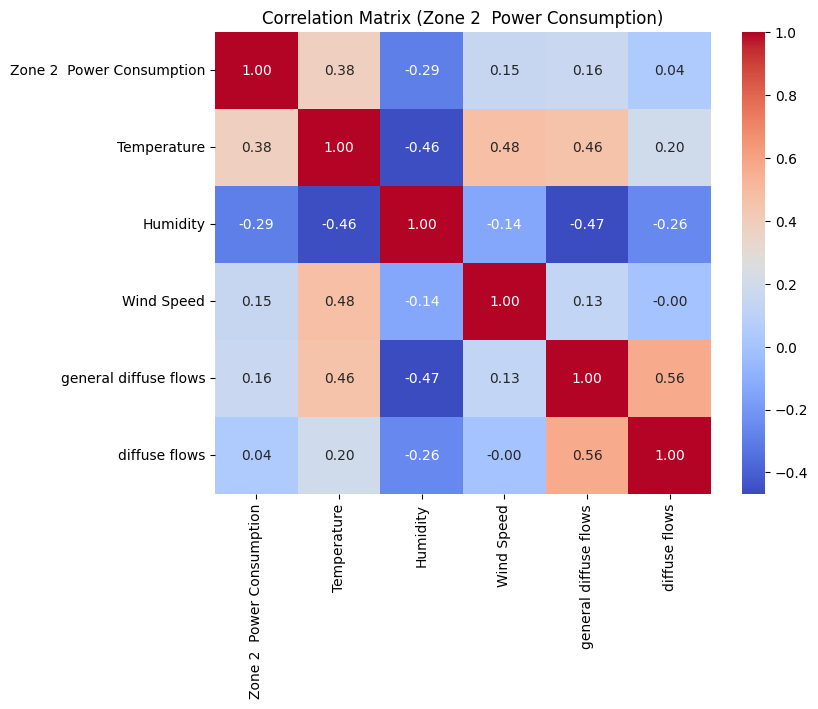

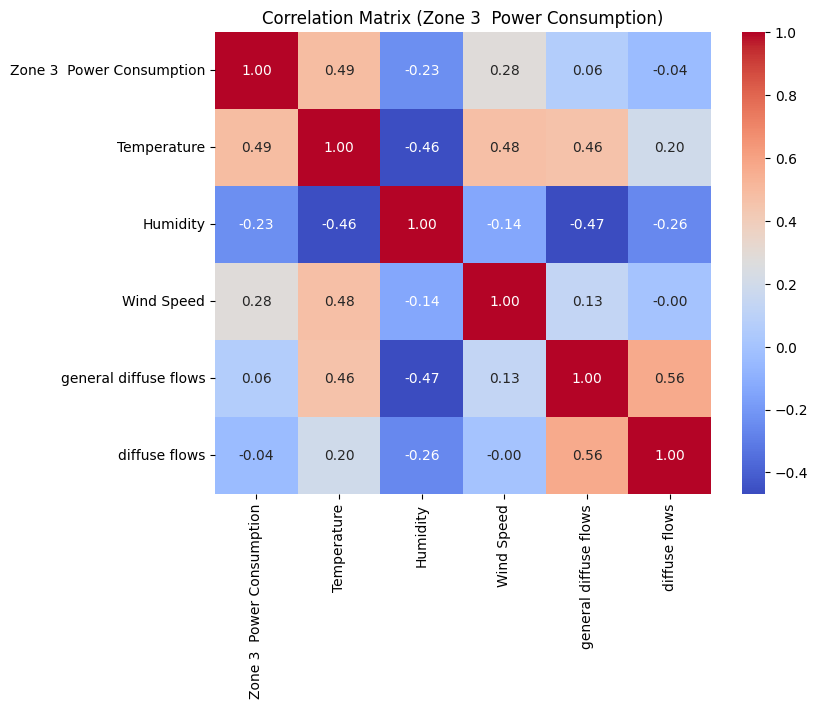

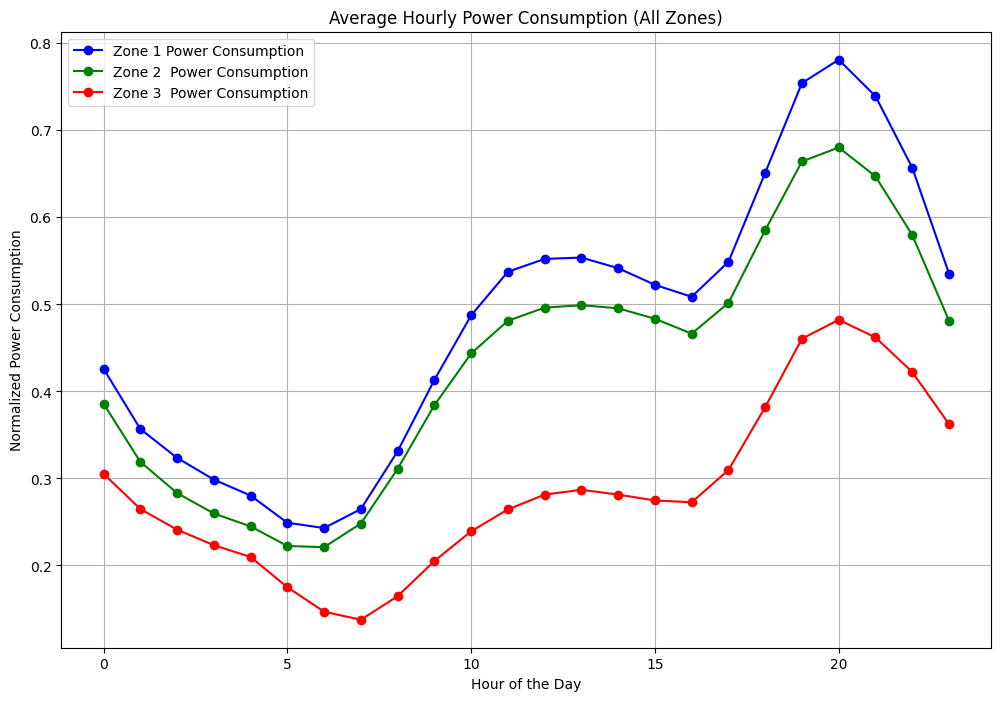

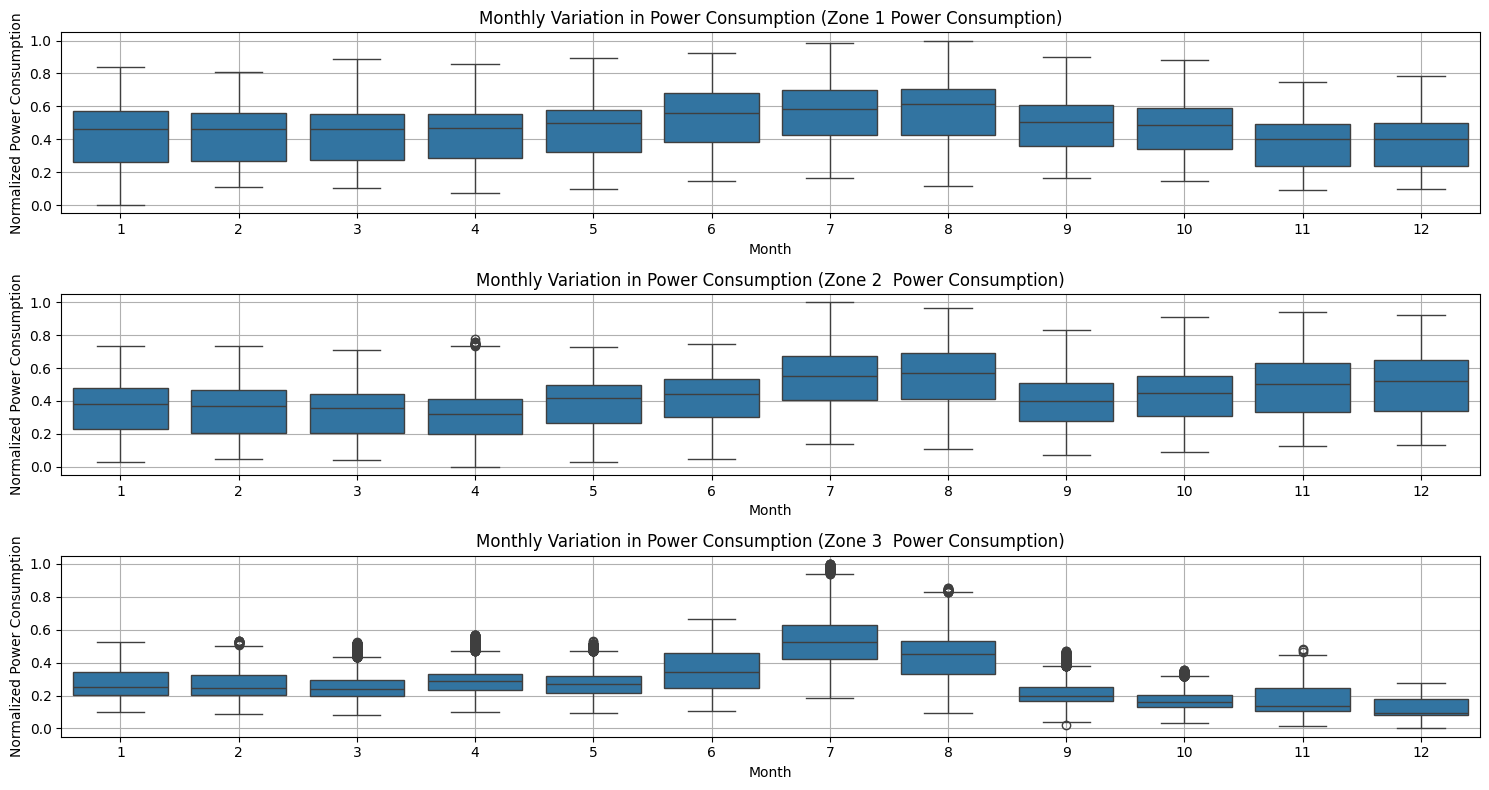

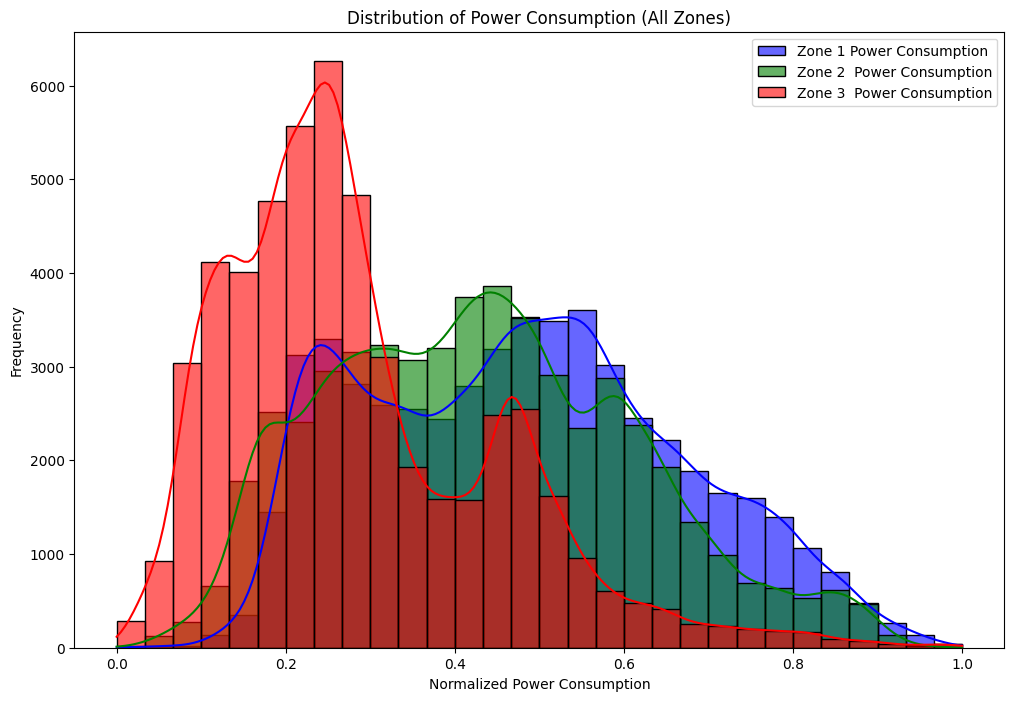

In [ ]:
# Correlation heatmaps for each zone
zones = ['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']
for zone in zones:
    corr_matrix_zone = data[[zone, 'Temperature', 'Humidity', 'Wind Speed',
                             'general diffuse flows', 'diffuse flows']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix_zone, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix ({zone})')
    plt.show()

# Hourly trends for Zone 1, Zone 2, and Zone 3
plt.figure(figsize=(12, 8))
zone_colors = {'Zone 1 Power Consumption': 'blue', 'Zone 2  Power Consumption': 'green', 'Zone 3  Power Consumption': 'red'}

for zone in zones:
    hourly_consumption = data.groupby('Hour')[zone].mean()
    plt.plot(hourly_consumption.index, hourly_consumption.values, marker='o', label=zone, color=zone_colors[zone])

plt.title('Average Hourly Power Consumption (All Zones)')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Power Consumption')
plt.legend()
plt.grid()
plt.show()

# Monthly boxplots for all zones
plt.figure(figsize=(15, 8))
for i, zone in enumerate(zones, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data['Month'], y=data[zone])
    plt.title(f'Monthly Variation in Power Consumption ({zone})')
    plt.xlabel('Month')
    plt.ylabel('Normalized Power Consumption')
    plt.grid()

plt.tight_layout()
plt.show()

# Distributions for all zones
plt.figure(figsize=(12, 8))
zone_colors = {'Zone 1 Power Consumption': 'blue', 'Zone 2  Power Consumption': 'green', 'Zone 3  Power Consumption': 'red'}

for zone in zones:
    sns.histplot(data[zone], kde=True, bins=30, label=zone, alpha=0.6, color=zone_colors[zone])

plt.title('Distribution of Power Consumption (All Zones)')
plt.xlabel('Normalized Power Consumption')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Correlation of features with each zone's power consumption
for zone in zones:
    print(f"\nCorrelation with {zone}:")
    print(data.corr()[zone].sort_values(ascending=False))


Correlation with Zone 1 Power Consumption:
Zone 1 Power Consumption     1.000000
Zone 2  Power Consumption    0.834519
Zone 3  Power Consumption    0.750733
Hour                         0.727953
Temperature                  0.440221
general diffuse flows        0.187965
Wind Speed                   0.167444
diffuse flows                0.080274
Day                          0.026273
DateTime                    -0.001910
Month                       -0.005346
Weekday                     -0.069708
Humidity                    -0.287421
Name: Zone 1 Power Consumption, dtype: float64

Correlation with Zone 2  Power Consumption:
Zone 2  Power Consumption    1.000000
Zone 1 Power Consumption     0.834519
Hour                         0.663359
Zone 3  Power Consumption    0.570932
Temperature                  0.382428
DateTime                     0.325206
Month                        0.320266
general diffuse flows        0.157223
Wind Speed                   0.146413
Day                         

In [ ]:
# Define features and target
features = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
            'diffuse flows', 'Hour', 'Day', 'Month', 'Weekday']

zone_targets = {
    'Zone 1': 'Zone 1 Power Consumption',
    'Zone 2': 'Zone 2  Power Consumption',
    'Zone 3': 'Zone 3  Power Consumption'
}

# Random Forest feature importance
for zone, target in zone_targets.items():
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
    print(f"\nFeature Importance for {zone}:")
    print(feature_importance)

# Recursive Feature Elimination (RFE) with Linear Regression
for zone, target in zone_targets.items():
    X = data[features]
    y = data[target]

    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=5)
    rfe.fit(X, y)

    print(f"\nTop Features Selected for {zone}:")
    print([features[i] for i in range(len(features)) if rfe.support_[i]])


Feature Importance for Zone 1:
Hour                     0.745816
Temperature              0.090599
Month                    0.071633
general diffuse flows    0.023032
Day                      0.021439
Weekday                  0.016657
diffuse flows            0.011393
Wind Speed               0.009752
Humidity                 0.009679
dtype: float64

Feature Importance for Zone 2:
Hour                     0.583881
Month                    0.224651
general diffuse flows    0.055961
Weekday                  0.042954
Day                      0.029519
Temperature              0.025643
Wind Speed               0.017772
Humidity                 0.010495
diffuse flows            0.009124
dtype: float64

Feature Importance for Zone 3:
Month                    0.458812
Hour                     0.363083
Temperature              0.111520
Day                      0.032533
general diffuse flows    0.014247
Wind Speed               0.006284
diffuse flows            0.005795
Humidity                

In [ ]:
# Define zone-specific targets
zone_targets = {
    'Zone 1': 'Zone 1 Power Consumption',
    'Zone 2': 'Zone 2  Power Consumption',
    'Zone 3': 'Zone 3  Power Consumption'
}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=6),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVM Regressor': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Loop through each zone or aggregated target
for zone, target in zone_targets.items():
    print(f"\nEvaluating models for {zone}...\n")

    # Define features and target
    X = data[features]
    y = data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    results = {}
    for model_name, model in models.items():
        if model_name in ['Linear Regression', 'KNN Regressor', 'SVM Regressor']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Evaluate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_var = explained_variance_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Explained Variance': explained_var,
            'Predictions': y_pred
        }

        # Print metrics
        print(f"\n{model_name} Performance for {zone}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Explained Variance: {explained_var:.4f}")


Evaluating models for Zone 1...


Linear Regression Performance for Zone 1:
  RMSE: 0.1100
  MAE: 0.0874
  R²: 0.6485
  Explained Variance: 0.6485

KNN Regressor Performance for Zone 1:
  RMSE: 0.0341
  MAE: 0.0223
  R²: 0.9661
  Explained Variance: 0.9661

Random Forest Performance for Zone 1:
  RMSE: 0.0251
  MAE: 0.0167
  R²: 0.9817
  Explained Variance: 0.9817

XGBoost Performance for Zone 1:
  RMSE: 0.0291
  MAE: 0.0211
  R²: 0.9754
  Explained Variance: 0.9754

SVM Regressor Performance for Zone 1:
  RMSE: 0.0594
  MAE: 0.0478
  R²: 0.8976
  Explained Variance: 0.8982

Evaluating models for Zone 2...


Linear Regression Performance for Zone 2:
  RMSE: 0.1431
  MAE: 0.1163
  R²: 0.3686
  Explained Variance: 0.4413

KNN Regressor Performance for Zone 2:
  RMSE: 0.1196
  MAE: 0.1007
  R²: 0.5589
  Explained Variance: 0.6357

Random Forest Performance for Zone 2:
  RMSE: 0.1163
  MAE: 0.0986
  R²: 0.5826
  Explained Variance: 0.6579

XGBoost Performance for Zone 2:
  RMSE: 0.1162
  

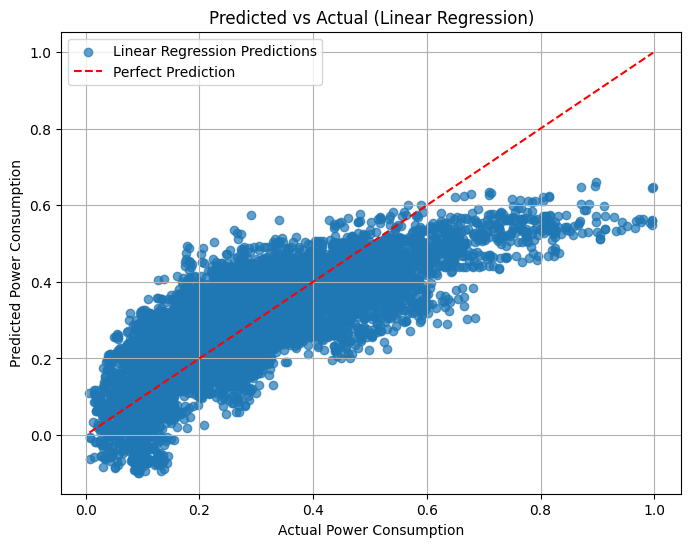

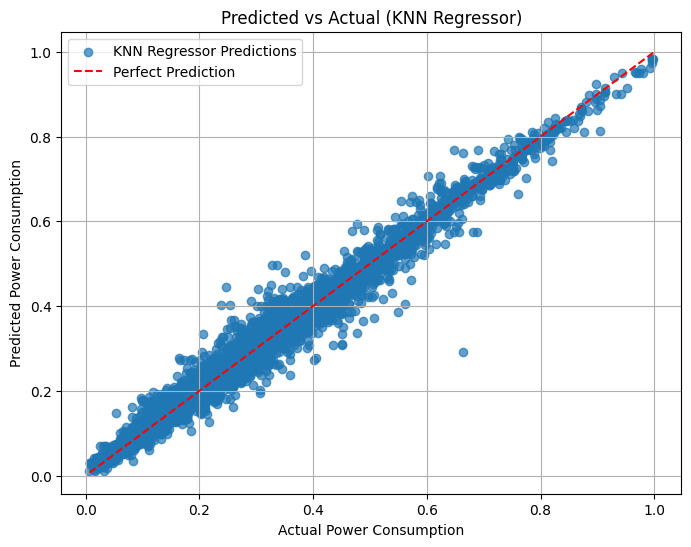

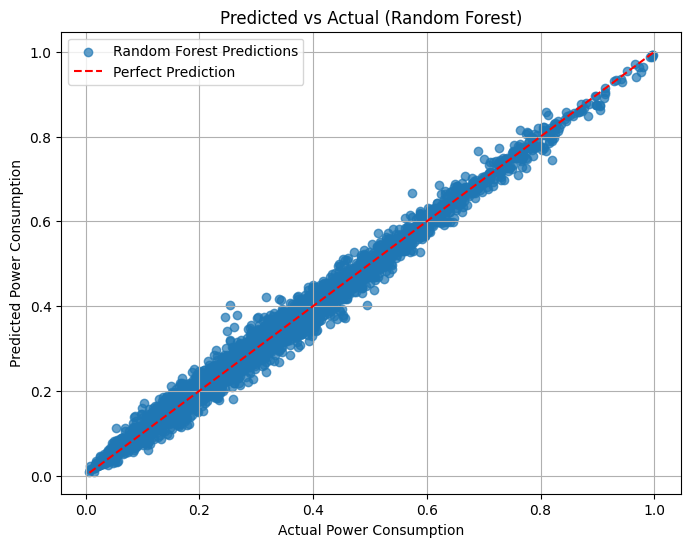

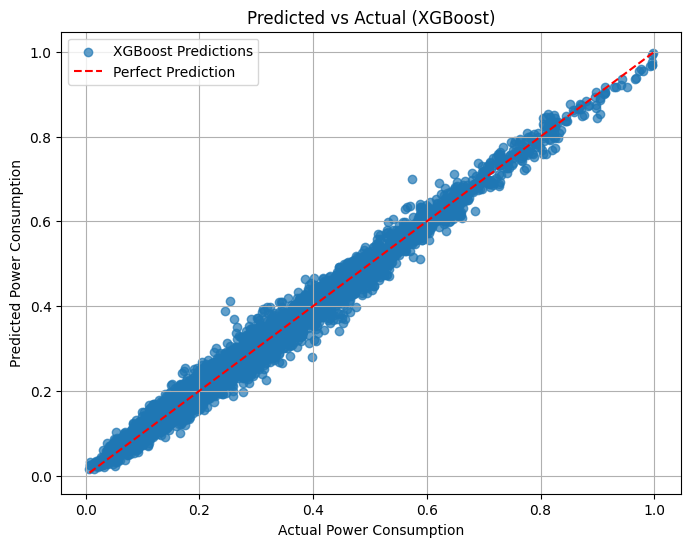

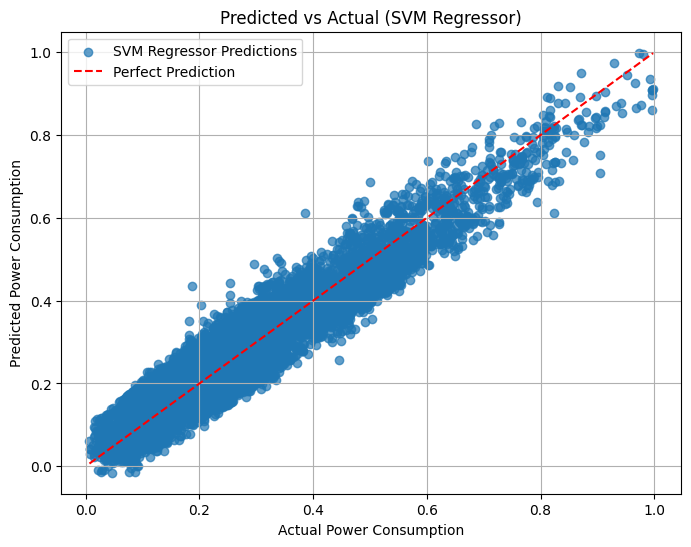

In [ ]:
# Visualize Predicted vs Actual for each model (unchanged)
for model_name, result in results.items():
    y_pred = result['Predictions']
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label=f'{model_name} Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs Actual ({model_name})')
    plt.xlabel('Actual Power Consumption')
    plt.ylabel('Predicted Power Consumption')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Aggregated target analysis
data['Total Power Consumption'] = data['Zone 1 Power Consumption'] + data['Zone 2  Power Consumption'] + data['Zone 3  Power Consumption']

X = data[features]
y = data['Total Power Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_total = RandomForestRegressor(random_state=42)
rf_total.fit(X_train, y_train)
y_pred_rf_total = rf_total.predict(X_test)
rmse_rf_total = np.sqrt(mean_squared_error(y_test, y_pred_rf_total))
r2_rf_total = r2_score(y_test, y_pred_rf_total)

xgb_total = XGBRegressor(random_state=42)
xgb_total.fit(X_train, y_train)
y_pred_xgb_total = xgb_total.predict(X_test)
rmse_xgb_total = np.sqrt(mean_squared_error(y_test, y_pred_xgb_total))
r2_xgb_total = r2_score(y_test, y_pred_xgb_total)

print(f"Random Forest (Total Power) RMSE: {rmse_rf_total}, R²: {r2_rf_total}")
print(f"XGBoost (Total Power) RMSE: {rmse_xgb_total}, R²: {r2_xgb_total}")

Random Forest (Total Power) RMSE: 0.05576316665940602, R²: 0.9861173854331906
XGBoost (Total Power) RMSE: 0.06394500792444507, R²: 0.9817446694759263
